In [1]:
from encoding import Encoding
from classification import Classification
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import matplotlib.pyplot as plt




(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()



1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


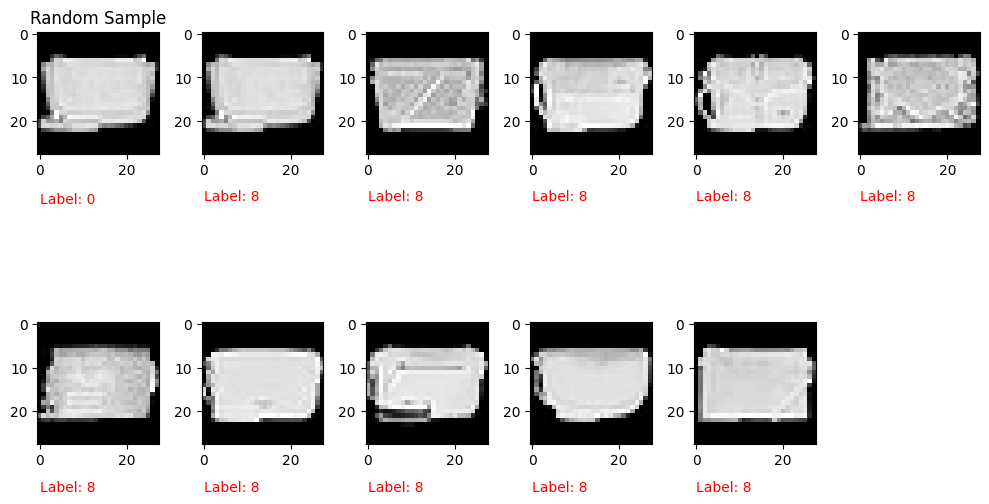

In [2]:
# Autoencoder model

enc = Encoding(x_train, x_test)

loss_fn = tf.keras.losses.MeanSquaredError()
enc.set_loss_function(loss_fn)

enc.set_seed(36)

latent_dim = 4**2
enc.set_latent_dim(latent_dim)

enc.normalize_data()


enc.reshaper()

enc.load_config('final_autoencoder_weights.weights.h5','final_autoencoder_config.yaml')
enc.compile_model('mse','adam')

enc.encode_predict()

enc.closest_samples(10,y_train,y_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


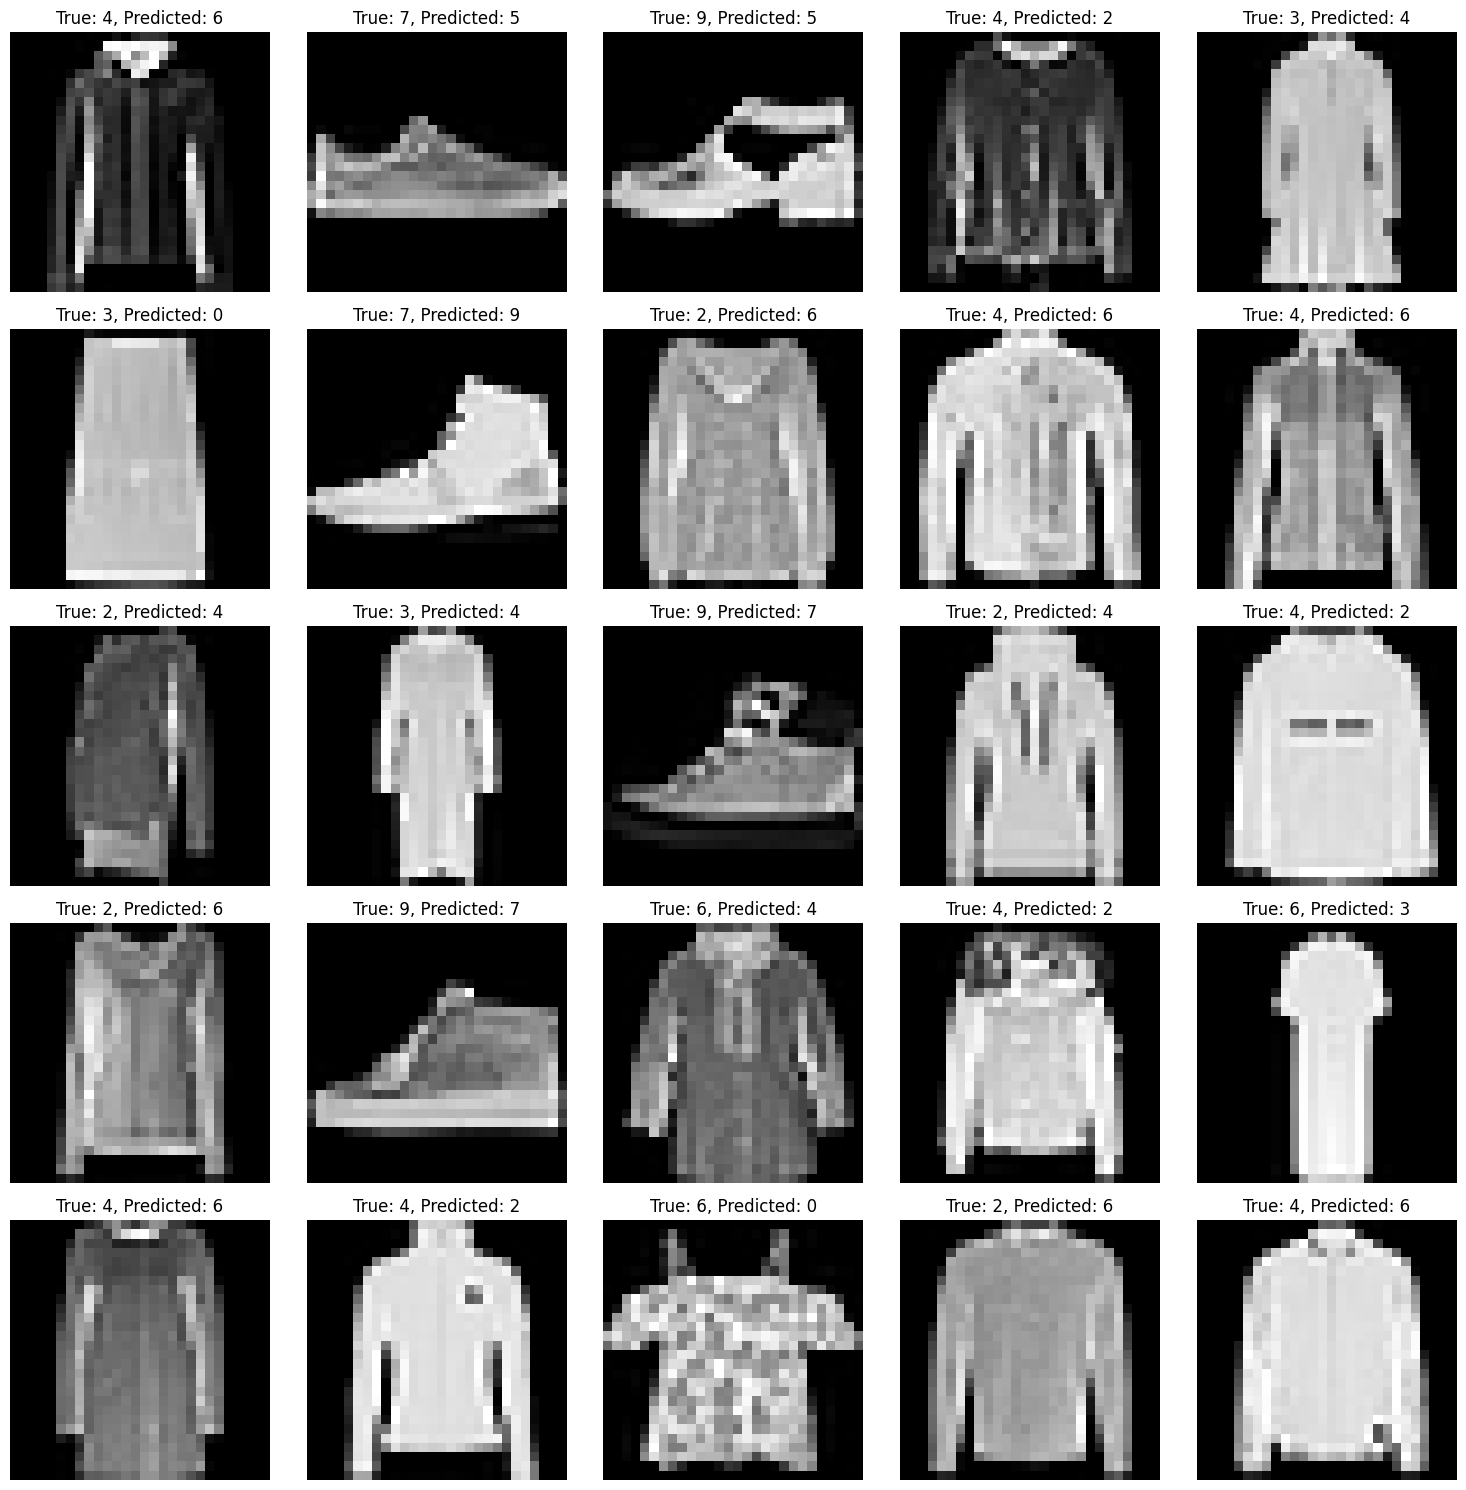

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


In [3]:
# Classification model

cf = Classification(x_train,y_train,x_test,y_test)


cf.set_seed(36)
cf.split_to_val(None)
cf.normalize_data()
cf.convert_to_binary_class_matrices(10)

cf.load_config(models.Sequential(),'final_model_weights.weights.h5',
                 'final_model_config.yaml')

cf.compile_model('adam',tf.keras.losses.CategoricalCrossentropy(),'accuracy')


y_pred = cf.predict_test()
misclassified_indices = np.where(y_pred != y_test)[0][:25]  # Get indices of 25 misclassified samples


num_rows = (25 // 5) + (1 if 25 % 5 != 0 else 0)
plt.figure(figsize=(15, 3 * num_rows))
for i, index in enumerate(misclassified_indices[:25]):
    plt.subplot(num_rows, 5, i + 1)
    plt.imshow(x_test[index], cmap='gray')
    plt.title(f'True: {y_test[index]}, Predicted: {y_pred[index]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Step 7: Find local examples and counterexamples for misclassified samples
local_examples = []
local_counterexamples = []

for index in misclassified_indices:
    # Extract misclassified sample
    misclassified_sample = x_test[index]
    true_label = y_test[index]
    predicted_label = y_pred[index]

    # Encode misclassified sample
    encoded_misclassified_sample = enc.autoencoder.predict(np.expand_dims(misclassified_sample, axis=0))
    encoded_misclassified_sample = encoded_misclassified_sample.reshape(encoded_misclassified_sample.shape[0], -1)
    encoded_x_train_reshaped = enc.encoded_x_train.reshape(enc.encoded_x_train.shape[0], -1)


    # Find local example (closest sample with same label)
    nn_same_label = NearestNeighbors(n_neighbors=1)
    nn_same_label.fit(encoded_x_train_reshaped[y_train == true_label].reshape(-1, encoded_x_train_reshaped.shape[1]))  # Only fit on samples with the same label
    _, local_example_index = nn_same_label.kneighbors(encoded_misclassified_sample)
    local_example_index = local_example_index[0][0]  # Extract index of local example
    local_example = cf.x_train[y_train == true_label][local_example_index]  # Retrieve local example
    local_examples.append(local_example)

    # Find local counterexample (closest sample with different label)
    nn_diff_label = NearestNeighbors(n_neighbors=1)
    nn_diff_label.fit(enc.encoded_x_train[y_train != true_label].reshape(-1, encoded_x_train_reshaped.shape[1]))  # Only fit on samples with a different label
    _, local_counterexample_index = nn_diff_label.kneighbors(encoded_misclassified_sample)
    local_counterexample_index = local_counterexample_index[0][0]  # Extract index of local counterexample
    local_counterexample = enc.x_train[y_train != true_label][local_counterexample_index]  # Retrieve local counterexample
    local_counterexamples.append(local_counterexample)

In [11]:
# Step 8: Note likely causes of misclassification
likely_causes = {
    1: "Noise",  
    2: "Mislabeling",
    3: "Underrepresentation",
    4: "Overfitting",
    5: "Underfitting",
    6: "Overlapping labels"
}

# Step 9: Write results to a CSV file
results_data = []


causes = ['Underrepresentation',
          'Underrepresentation',
          'Underrepresentation',
          'Underrepresentation',
          'Underfitting',
          'Overfitting',
          'Overfitting',
          'Underrepresentation',
          'Underfitting',
          'Underrepresentation',
          'Underrepresentation',
          'Underrepresentation',
          'Overfitting',
          'Underrepresentation',
          'Underfitting',
          'Overfitting',
          'Underrepresentation',
          'Underrepresentation',
          'Underrepresentation',
          'Overfitting',
          'Overfitting',
          'Underrepresentation',
          'Overfitting',
          'Underrepresentation',
          'Underrepresentation',
          'Underfitting'
          ]

for index, misclassified_index in enumerate(misclassified_indices):
    # Extract misclassified sample and its details
    misclassified_sample = x_test[misclassified_index]


    # Manually analyze the misclassified sample and determine the likely cause
    # For demonstration purposes, let's assume the likely cause is "Noise"
    likely_cause = causes[index]

    results_data.append({
        "Misclassified Sample": misclassified_sample,
        "Likely Cause": likely_cause
    })

# Write results to CSV file
results_df = pd.DataFrame(results_data)
results_df.to_csv("misclassification_analysis.csv", index=False)

# Step 10: Load CSV into a Pandas DataFrame and display distribution of likely causes
misclassification_analysis = pd.read_csv("misclassification_analysis.csv")
likely_cause_distribution = misclassification_analysis["Likely Cause"].value_counts()

print("Distribution of likely causes of misclassification:")
print(likely_cause_distribution)

Distribution of likely causes of misclassification:
Likely Cause
Underrepresentation    15
Overfitting             7
Underfitting            3
Name: count, dtype: int64


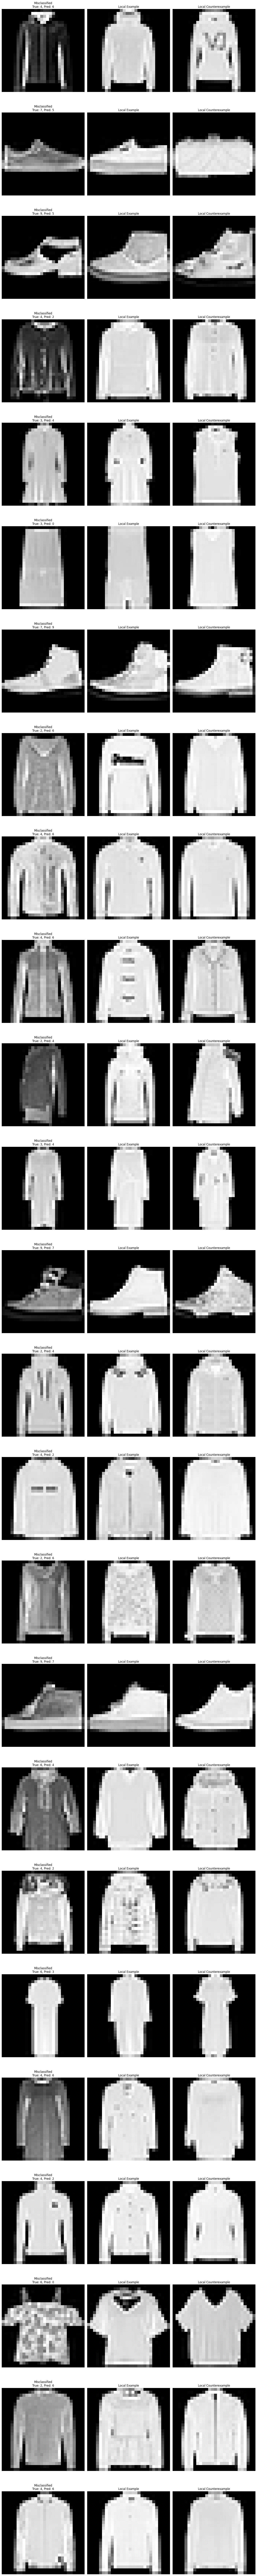

In [6]:
num_samples = len(misclassified_indices)
plt.figure(figsize=(15, 6 * num_samples))

for i, index in enumerate(misclassified_indices):
    # Plot misclassified sample
    plt.subplot(num_samples, 3, 3 * i + 1)
    plt.imshow(x_test[index], cmap='gray')
    plt.title(f'Misclassified\nTrue: {y_test[index]}, Pred: {y_pred[index]}')
    plt.axis('off')
    
    # Plot local example
    plt.subplot(num_samples, 3, 3 * i + 2)
    plt.imshow(local_examples[i], cmap='gray')
    plt.title('Local Example')
    plt.axis('off')
    
    # Plot local counterexample
    plt.subplot(num_samples, 3, 3 * i + 3)
    plt.imshow(local_counterexamples[i], cmap='gray')
    plt.title('Local Counterexample')
    plt.axis('off')

plt.tight_layout()
plt.show()

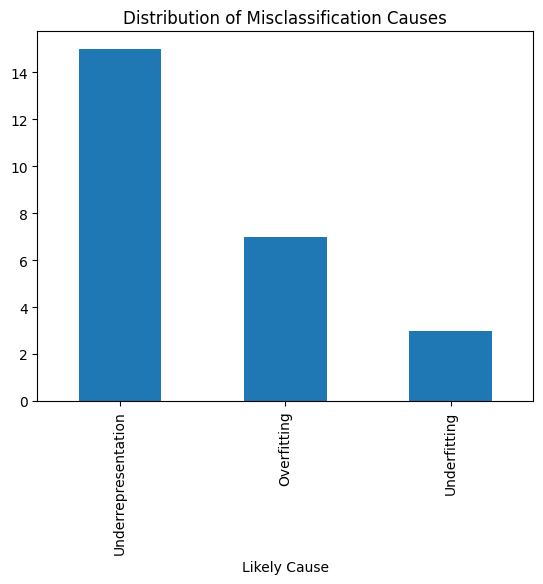

In [12]:
df_loaded = pd.read_csv('misclassification_analysis.csv')
cause_counts = df_loaded['Likely Cause'].value_counts()
cause_counts.plot(kind='bar')
plt.title('Distribution of Misclassification Causes')
plt.show()